In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 
from kneed import KneeLocator


# Load the data

In [2]:
dfile = open("ccrescentus.fa","r") #downloaded from www.ihes.fr/~zinovyev/pcadg/
dfile.readline() #skip first line
gene =''
for line in dfile:
    gene = gene + line.rstrip() #gene is full gene, there are some newline characters which need to be stripped



dfile.close()
print(gene[:20]) #check end of string to make sure no info is appended. 


gccgatagcctatgatcccc


In [3]:
# Check length of gene and how many 300 letter fragments to split in. 
FullLen = len(gene)
print(FullLen)
indexMult = int(FullLen/300)
print(indexMult)
print(indexMult*300)


305400
1018
305400


# Break the gene into fragments of size 300 letters

In [4]:
wordLst =[] 
#firstWord = gene[0:300]
#wordLst.append(firstWord)
for i in range(0,indexMult):
    strtIndx = i*300
    endIndx = (i+1)*300
    word = gene[strtIndx:endIndx]
    wordLst.append(word)
    

In [5]:
wordLst[1]

'cgaagggttggacgagaacttgctgcggtagctgccgtcatagccgacatagaactcgcccgtcttgcccaggaagtcgcccggaacattggcctcggcccccagggccacgctccacttcgaaacgcccggcagccgctgacccgagacgtcgcagttggcggggctgagcgcgccggccacgccggccgcgcgcggaacctgggttccggtcgccaccgtgccgcccgacagttccggcgggcagggcgcgtcgacaaagcgcacatacttggcgtcggtataggcggcgttcagata'

In [6]:
#This function is not used anywhere in this project - it was written for curiosity.
#It produces all arrangements of a given list of letters
def arrange(set1,c,result):
    len1 = len(set1)
    
    if len1!=2:

        for i in range(0,len1):
            X=c+str( set1[i])
            set2=[]
            for j in range(0,len1):
                if i!=j:
                    set2.append(set1[j])
            arrange(set2,X,result)
    else:
        
        #print(c+str(set1[0])+str(set1[1]))
        r1 =c+str(set1[0])+str(set1[1])
        result.append(r1)
        #print (c+str(set1[1])+str(set1[0]))
        r2 =c+str(set1[1])+str(set1[0])
        result.append(r2)
        
        c=""
        #return result

# Find all possible combinations of 4 letters of the gene, grouped word size:  2, 3 or 4 at a time

In [7]:
#This function is used to produced all combinations with repetition of letters up to a certain word length. 
def allCombinations(lst,c,wordLen,result):
    len1 = len(lst)
    if wordLen!=1:
        for i in range(0,len1):
            X = c+lst[i]
            allCombinations(lst,X,wordLen-1,result)
            
    else:
        for elm in lst:
            r1 = c+elm
            #print(r1)
            result.append(r1)
    
        
            
    
    

In [8]:
#Call the function above to 
singlet =['a','c','g','t']
allCombo2=[]
allCombo3 =[]
allCombo4 =[]
allCombinations(singlet,'',2,allCombo2)
allCombinations(singlet,'',3,allCombo3)
allCombinations(singlet,'',4,allCombo4)
#len(allCombo)

# Split the 300 letter fragments into smaller words of 2, 3 or 4 letters, count frequency against all possible combinations. 

In [9]:
def fragmentSplit(fragment,n):
    lenFrag = len(fragment)
    indxMult = int(lenFrag/n)
    #print(indxMult)
    smallwordLst =[] 

    for i in range(0,indxMult):
        strtIndx = i*n
        endIndx = (i+1)*n
        word = fragment[strtIndx:endIndx]
        smallwordLst.append(word)
    return smallwordLst


In [10]:
def countFreq(buckets,wordLst,n):
    countDict ={}
    
    for bucket in buckets:
        row =[]
        for fragment in wordLst:
            splitFragment = fragmentSplit(fragment,n)
            occurance = splitFragment.count(bucket)
            row.append(occurance)
        countDict[bucket] = row
    return countDict
        
        

In [11]:
splitW0 = fragmentSplit(wordLst[0],3)
print(splitW0)

['gcc', 'gat', 'agc', 'cta', 'tga', 'tcc', 'ccg', 'gca', 'ggc', 'ccg', 'ggg', 'ctt', 'gga', 'gcc', 'gtc', 'tgg', 'ttt', 'gga', 'tgg', 'aac', 'cct', 'cca', 'aac', 'cag', 'atc', 'aag', 'agg', 'ctc', 'cta', 'gaa', 'cgc', 'cgc', 'ccg', 'cag', 'ggt', 'cac', 'gcc', 'cca', 'ggt', 'gcg', 'cgg', 'gtc', 'gcc', 'cgg', 'ctg', 'gcc', 'ggc', 'gat', 'cag', 'gcc', 'ggt', 'gtt', 'gct', 'ggg', 'acc', 'cac', 'ggc', 'cag', 'ttg', 'ctc', 'gaa', 'ata', 'gtt', 'ctc', 'gtc', 'gaa', 'ggc', 'gtt', 'gcg', 'gac', 'cca', 'ggc', 'ata', 'gag', 'gtt', 'cag', 'ccc', 'ctc', 'agg', 'cgt', 'gcg', 'gaa', 'gcc', 'ggc', 'ccg', 'gaa', 'gtt', 'agc', 'gat', 'cgt', 'gta', 'gcc', 'gtc', 'aac', 'cca', 'ggt', 'gta', 'gat', 'cga', 'ggg']


# Example word length: 2, combinations=4^2 (four letters, combined 2 at a time with repetition), perform PCA to see if a pattern emerges. 

In [12]:
freq2 = countFreq(allCombo2,wordLst,2)
df_2LW = pd.DataFrame.from_dict(freq2) #dataframe of two letter word
df_2LW.head()

,aa,ac,ag,at,ca,cc,cg,ct,ga,gc,gg,gt,ta,tc,tg,tt
0,6,6,17,6,6,21,10,3,4,16,20,11,3,10,6,5
1,7,6,8,2,12,17,19,7,5,22,17,8,4,4,6,6
2,0,5,11,5,6,14,19,5,8,21,14,7,1,13,12,9
3,4,7,10,0,9,9,18,9,6,20,17,11,6,6,13,5
4,3,5,14,4,7,10,12,11,12,16,14,8,0,11,15,8


In [13]:
df2 = StandardScaler().fit_transform(df_2LW)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df2)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

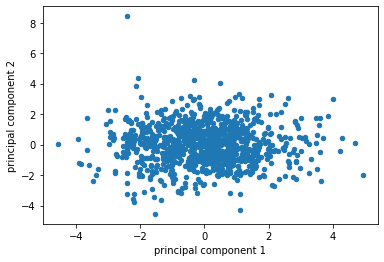

In [14]:
principalDf.plot.scatter(x = 'principal component 1',y='principal component 2' )

Conclusion: just a blob, no visible pattern.


# Example word length: 3, combinations=4^3 (64), perform PCA to see if a pattern emerges. 

In [15]:
freq3 = countFreq(allCombo3,wordLst,3)
df_3LW = pd.DataFrame.from_dict(freq3) #dataframe of three letter word
display(df_3LW.head())
display(df_3LW.describe())

,aaa,aac,aag,aat,aca,acc,acg,act,aga,agc,...,tcg,tct,tga,tgc,tgg,tgt,tta,ttc,ttg,ttt
0,0,3,1,0,0,1,0,0,0,2,...,0,0,1,0,2,0,0,0,1,1
1,1,3,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,1,3,0


,aaa,aac,aag,aat,aca,acc,acg,act,aga,agc,...,tcg,tct,tga,tgc,tgg,tgt,tta,ttc,ttg,ttt
count,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,...,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000
mean,0.365422,0.830059,1.324165,0.289784,0.757367,1.687623,1.861493,0.487230,1.005894,1.857564,...,2.944990,1.028487,1.350688,1.549116,2.287819,0.722004,0.144401,1.372299,0.927308,0.423379
std,0.687050,1.193888,1.778000,0.592906,1.230180,1.871135,1.988529,0.853205,1.331106,1.783335,...,2.833449,1.316327,1.629317,1.819820,2.281702,1.041106,0.413362,1.729466,1.571821,0.738413
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,...,2.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,2.000000,0.000000,1.000000,3.000000,3.000000,1.000000,2.000000,3.000000,...,4.000000,2.000000,2.000000,2.000000,4.000000,1.000000,0.000000,2.000000,1.000000,1.000000
max,6.000000,7.000000,14.000000,4.000000,12.000000,11.000000,13.000000,7.000000,9.000000,11.000000,...,14.000000,8.000000,8.000000,10.000000,13.000000,6.000000,3.000000,13.000000,11.000000,5.000000


<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

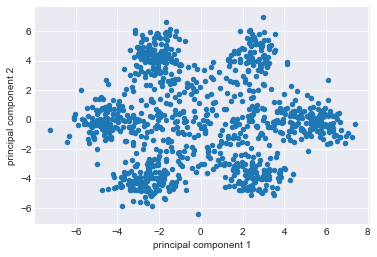

In [60]:

df3 = StandardScaler().fit_transform(df_3LW)

pca = PCA(n_components=2)

#reduced data
principalComponents = pca.fit_transform(df3)

principalDf3 = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf3.plot.scatter(x = 'principal component 1',y='principal component 2' )

# K-Means Clustering Applied to the PCA-data

We present some code for choosing the number of clusters using iteration through:
1. SSE
2. Silhouette Coeff - which is metric to measure the effectiveness of clustering 

In [37]:
kmeans_kwargs = {
    "init":"random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

In [38]:
sse = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(principalComponents)
    sse.append(kmeans.inertia_)

Text(0, 0.5, 'SSE')

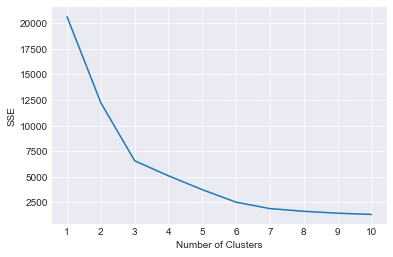

In [39]:
plt.style.use("seaborn-darkgrid")
plt.plot(range(1,11),sse)
plt.xticks(range(1,11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")

In [40]:
kl =   KneeLocator(range(1,11),sse,curve="convex",direction="decreasing")
kl.elbow

3

In [41]:
silhouette_coeff = []
for k in range(2,11): #min 2 clusters are needed
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(principalComponents)
    score = silhouette_score(df3,kmeans.labels_)
    silhouette_coeff.append(score)

Text(0, 0.5, 'silhouette_coeff')

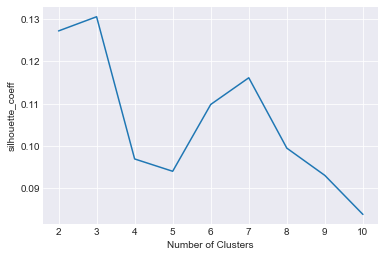

In [42]:
plt.style.use("seaborn-darkgrid")
plt.plot(range(2,11),silhouette_coeff)
plt.xticks(range(2,11))
plt.xlabel("Number of Clusters")
plt.ylabel("silhouette_coeff")

Based on the SSE plot, knee locator, PCA image and silhouette coeff, I choose clusters = 3 or 7.
Visually from PCA plot, 7 makes more sense. 


In [63]:
kmeans = KMeans(n_clusters=7, **kmeans_kwargs)
kmeans.fit(principalComponents)
y_kmeans = kmeans.predict(principalComponents)
centers = kmeans.cluster_centers_

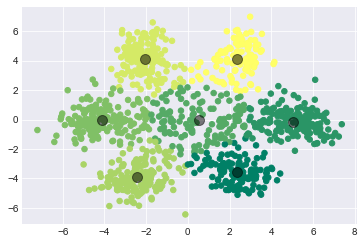

In [66]:
plt.scatter(principalDf3['principal component 1'], principalDf3['principal component 2'], c = y_kmeans, s = 30, cmap = 'summer')


plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5);

# Example word length: 4, combinations=4^4 (256), perform PCA to see if a pattern emerges. 

<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

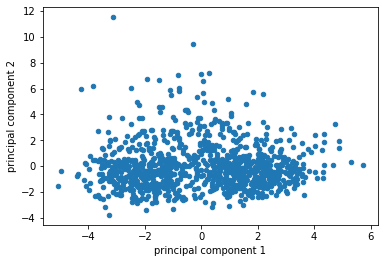

In [42]:
freq4 = countFreq(allCombo4,wordLst,4)
df_4LW = pd.DataFrame.from_dict(freq4) #dataframe of two letter word
df_4LW.head()
df4 = StandardScaler().fit_transform(df_4LW)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df4)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.plot.scatter(x = 'principal component 1',y='principal component 2' )

Conclusion: No distinguishable pattern. 